In [183]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_results_dict(dir, filename):
    with open(dir+'/'+filename, 'rb') as f:
        results = pkl.load(f)
    return results

date = '2024-09-26'
# date = '2024-09-24'
dir = 'heterogeneity_results'
fixed_name = '_single_task_exp_'
suffix = ' (1)'
filenames = {
    'ddn': {
        'distributed': {
            'cluster': date + fixed_name + 'DDN_dist_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'DDN_dist_decay_net_wide' + suffix + '.p'
        },
        'fixed': {
            'cluster': date + fixed_name + 'DDN_fixed_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'DDN_fixed_decay_net_wide' + suffix + '.p',
        }
    },
    'esn': {
        'distributed': {
            'cluster': date + fixed_name + 'BL_dist_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'BL_dist_decay_net_wide' + suffix + '.p',
        },
        'fixed': {
            'cluster': date + fixed_name + 'BL_fixed_decay_per_cluster' + suffix + '.p',
            'network': date + fixed_name + 'BL_fixed_decay_net_wide' + suffix + '.p',
        }
    }
}

In [184]:
results_dicts = {}
for factor_1 in filenames:
    results_dicts[factor_1] = {}
    for factor_2 in filenames[factor_1]:
        results_dicts[factor_1][factor_2] = {}
        for factor_3 in filenames[factor_1][factor_2]:
            print('loading: ' + filenames[factor_1][factor_2][factor_3])
            results_dicts[factor_1][factor_2][factor_3] = load_results_dict(dir, filenames[factor_1][factor_2][factor_3])

loading: 2024-09-26_single_task_exp_DDN_dist_decay_per_cluster (1).p
loading: 2024-09-26_single_task_exp_DDN_dist_decay_net_wide (1).p
loading: 2024-09-26_single_task_exp_DDN_fixed_decay_per_cluster (1).p
loading: 2024-09-26_single_task_exp_DDN_fixed_decay_net_wide (1).p
loading: 2024-09-26_single_task_exp_BL_dist_decay_per_cluster (1).p
loading: 2024-09-26_single_task_exp_BL_dist_decay_net_wide (1).p
loading: 2024-09-26_single_task_exp_BL_fixed_decay_per_cluster (1).p
loading: 2024-09-26_single_task_exp_BL_fixed_decay_net_wide (1).p


In [185]:
# dict keys example
print(results_dicts['ddn']['distributed']['cluster'].keys())

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data', 'alphas', 'start net'])


## Evolution 

In [186]:
def get_validation_throughout_evolution(dict, gen_max, populations=False):
    # Validation scores are saved in a matrix with dimensions:
    # generations x hyperparameter candidates x re-initializations x lag search grid
    all_scores = dict['validation performance'][:gen_max, :, :, :]
    
    # from the lag search grid we select the best score (lowest NRMSE), since this was the best 
    # performing readout model
    best_lag_scores = np.min(all_scores, axis=-1)
    
    # from the re-initializations from the same hyperparameter set/candidate, we take the average
    best_candidate_scores = np.mean(best_lag_scores, axis=-1)
    
    if populations:
        return best_candidate_scores
    
    # from the population of hyperparameter candidates, we select the best candidate
    best_gen_scores = np.min(best_candidate_scores, axis=-1)
    return best_gen_scores

In [191]:
gen_max = 90
val_scores = {}
for factor_1 in results_dicts:
    val_scores[factor_1] = {}
    for factor_2 in results_dicts[factor_1]:
        val_scores[factor_1][factor_2] = {}
        for factor_3 in results_dicts[factor_1][factor_2]:
            val_scores[factor_1][factor_2][factor_3] = get_validation_throughout_evolution(results_dicts[factor_1][factor_2][factor_3], gen_max)

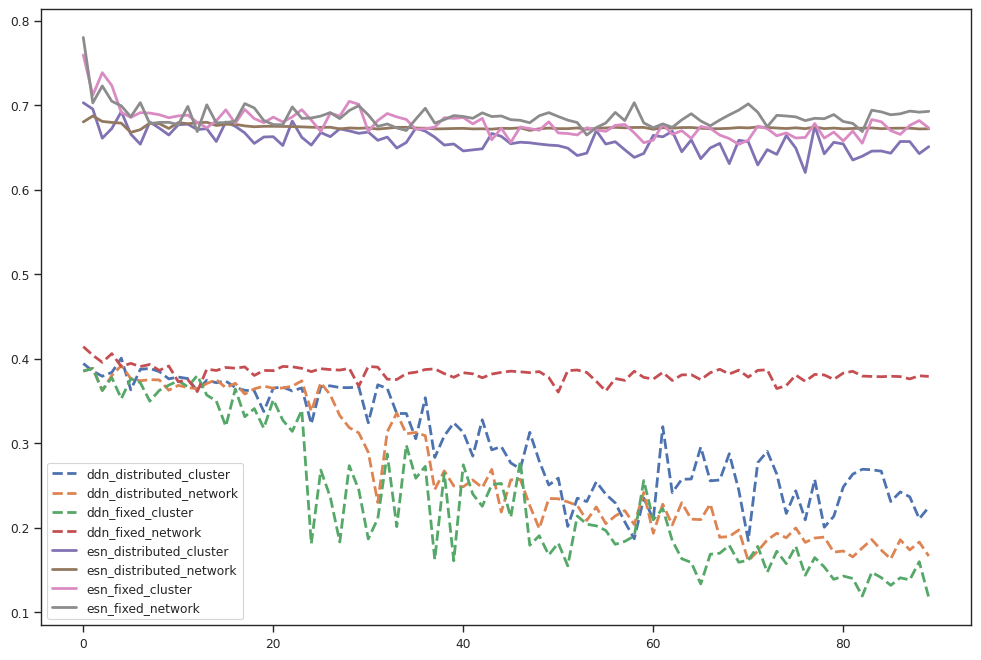

In [192]:
sns.set_theme(style="ticks", font_scale=1, palette='deep', context='paper')

plt.figure(figsize=(12,8))
gen_start = 0
gen_end = gen_max
for factor_1 in val_scores:
    for factor_2 in val_scores[factor_1]:
        for factor_3 in val_scores[factor_1][factor_2]:
            line = '-'
            if factor_1 == 'ddn':
                line = '--'
            plt.plot(val_scores[factor_1][factor_2][factor_3][gen_start:gen_end], label=factor_1 + '_' + factor_2 + '_' + factor_3, linestyle=line, linewidth=2)
            
plt.legend()

In [196]:
def get_best_candidate(dict, gen_max):
    best_gen_scores = get_validation_throughout_evolution(dict, gen_max) 
    best_candidates = get_validation_throughout_evolution(dict, gen_max, populations=True)
    best_gen_ind = np.argmin(best_gen_scores)
    best_candidate_ind = np.argmin(best_candidates[best_gen_ind])
    return best_gen_ind, best_candidate_ind
    
def sample_best_net(dict, n, gen_max):
    gen, ind = get_best_candidate(dict, gen_max)
    print(gen, ind)
    start_net = dict['example net']
    best_parameter_set = dict['parameters'][gen, ind, :]
    best_nets = []
    for i in range(n):
        best_net = start_net.get_new_network_from_serialized(best_parameter_set)
        best_nets.append(best_net)
    return best_nets


In [197]:
final_nets = {}
for factor_1 in results_dicts:
    final_nets[factor_1] = {}
    for factor_2 in results_dicts[factor_1]:
        final_nets[factor_1][factor_2] = {}
        for factor_3 in results_dicts[factor_1][factor_2]:
            best_nets = sample_best_net(results_dicts[factor_1][factor_2][factor_3], 15, gen_max)
            final_nets[factor_1][factor_2][factor_3] = best_nets

70 16
70 1
89 13
50 10
76 6
5 15
69 14
53 8


In [198]:
from utils import eval_candidate_lag_gridsearch_NARMA, createNARMA30

data_train = np.array(createNARMA30(8000)).reshape((2, 8000))
data_test = np.array(createNARMA30(4000)).reshape((2, 4000))
alphas = [10e-7, 10e-5, 10e-3]
    
test_results = {
    'Test NRMSE' : [],
    'Network type': [],
    'Distribution heterogeneity': [],
    'Cluster heterogeneity': []
}

def write(dict, score, net_type, f1, f2):
    dict['Test NRMSE'].append(score)
    dict['Network type'].append(net_type)
    dict['Distribution heterogeneity'].append(f1)
    dict['Cluster heterogeneity'].append(f2)
    
for factor_1 in final_nets:
    for factor_2 in final_nets[factor_1]:
        for factor_3 in final_nets[factor_1][factor_2]:
            for net in final_nets[factor_1][factor_2][factor_3]:
                _, val_scores_lags, _ = eval_candidate_lag_gridsearch_NARMA(net, data_train, data_test,alphas=alphas)
                best_lag_score = np.min(val_scores_lags)
                write(test_results, best_lag_score, factor_1, factor_2, factor_3)

In [202]:
test_df = pd.DataFrame.from_dict(test_results)
test_df_esn = test_df[test_df['Network type'] == 'esn']
test_df_ddn = test_df[test_df['Network type'] == 'ddn']
test_df_esn.head()

,Test NRMSE,Network type,Distribution heterogeneity,Cluster heterogeneity
60,0.607736,esn,distributed,cluster
61,0.643942,esn,distributed,cluster
62,0.645248,esn,distributed,cluster
63,0.622176,esn,distributed,cluster
64,0.639815,esn,distributed,cluster


<AxesSubplot: xlabel='Distribution heterogeneity', ylabel='Test NRMSE'>

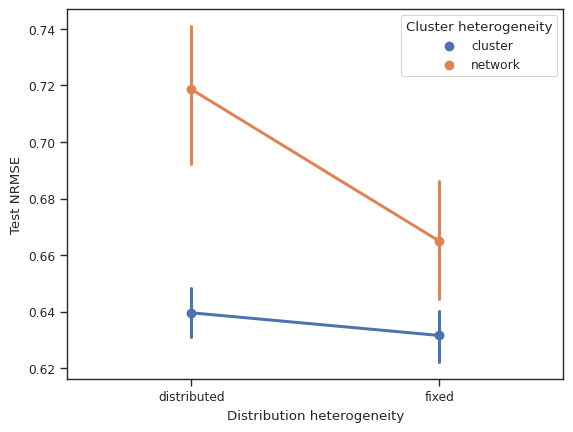

In [203]:
sns.pointplot(test_df_esn, x='Distribution heterogeneity', y='Test NRMSE', hue='Cluster heterogeneity',)

<AxesSubplot: xlabel='Distribution heterogeneity', ylabel='Test NRMSE'>

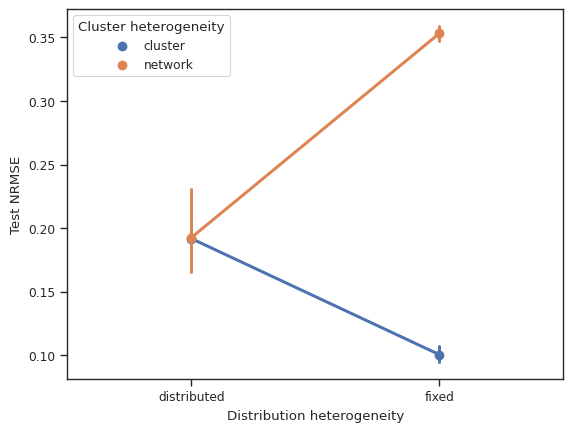

In [204]:
sns.pointplot(test_df_ddn, x='Distribution heterogeneity', y='Test NRMSE', hue='Cluster heterogeneity',)

## Heterogeneity Measure